# Bayes Klassifikator mit Normalverteilungsannahme


## Modell

![](../images/klassifikator.png)

- Modell: Die Muster sind klassenweise normalverteilt.
- Parameter: pro Klasse benötigen wir Mittelwert, Kovarianzmatrix und
a-priori-Wahrscheinlichkeit
- Algorithmus: Berechne a-posteriori-Wahrscheinlichkeit für alle Klassen und
gebe wahrscheinlichste Klasse aus.


## Quellcode

Der folgende Python-Code realisiert einen Bayes Klassifikator mit Normalverteilungsannahme. (Er ist auch in der Datei **bayes.py** zu finden.)

In [1]:
import numpy as np
import math

class NormalBayes(object):
    """"Bayes classifier.

    Parameters
    ------------
    none
    
    Attributes
    -----------
    mean_ : mean vectors of each class
    kova_ : kovariance matrices
    apri_ : a-priori probabilities
    """
 
    labels_ = []
    mean_ = {}
    kova_ = {}
    freq_ = {}
    apri_ = {}
        
    def __init__(self):
        pass
    
    # calculate normal density
    def norm_pdf(self, x, mu, sigma):
        size = len(x)
        if size == len(mu) and (size, size) == sigma.shape:
            # determinant
            det = np.linalg.det(2*math.pi*sigma)
            if det == 0:
                raise NameError("Die Kovarianzmatrix darf nicht singulär sein")

            # factor in front of exp
            norm_const = 1.0 / math.pow(det,0.5)
            x_mu = np.matrix(x - mu)
            inv = np.linalg.inv(sigma)       
            result = math.pow(math.e, -0.5 * (x_mu * inv * x_mu.T))
            return norm_const * result
        else:
            raise NameError("Dimensionen passen nicht")
    
    
    def fit(self, X, y):
        """Fit training data.

        Parameters
        ----------
        X : {array-like}, shape = [n_samples, n_features]
            Training vectors, where n_samples is the number of samples and
            n_features is the number of features.
        y : array-like, shape = [n_samples]
            Target values.

        Returns
        -------
        none

        """
        
        self.labels_ = []
        self.mean_ = {}
        self.kova_ = {}
        self.freq_ = {}
        self.apri_ = {}
        
        # estimate mean vectors
        for sample,k in zip(X,y):
            if k not in self.labels_:
                self.labels_.append(k)
                self.mean_[k] = sample
                self.freq_[k] = 1
            else:
                self.mean_[k] += sample
                self.freq_[k] += 1
        
        for k in self.labels_:
            self.mean_[k] /= self.freq_[k]
            
        # estimate covariance matrices
        for sample,k in zip(X,y):
            x_minus_mu = sample - self.mean_[k]
            if k not in self.kova_:
                self.kova_[k] = np.outer(x_minus_mu,x_minus_mu)
            else:
                self.kova_[k] += np.outer(x_minus_mu,x_minus_mu)
                
        for k in self.labels_:
            self.kova_[k] /= self.freq_[k]
            
        # estimate a-priori
        samples = len(X)
        for k in self.labels_:
            self.apri_[k] = self.freq_[k]/samples
            
       
    def predict(self,X):
        """Return class label with highest a-posteriori probability"""
        Y = []
        for sample in X:
            results = []
            for k in self.labels_:
                results.append(self.norm_pdf(sample,self.mean_[k],self.kova_[k])*self.apri_[k])
            Y.append(self.labels_[np.argmax(results)])
        return Y

## Klassifikation mit scikit-learn


Schritte:

1. Einlesen der benötigten Daten
2. Aufrufen des Konstruktors für den Klassifikator
3. Trainieren des Klassifikators mit der Methode ```fit()```
4. Klassifizieren der Testmuster mit der Methode  ```predict()```
5. Ausgabe des Resultats

## Beispiel: Klassifikation der Iris-Daten

Schritt 1: Daten einlesen

In [2]:
import pandas as pd

traindata = pd.read_csv('../datasets/iris/iris.data',header=None)
traindata.columns=['Länge Kelchblatt','Breite Kelchblatt', 'Länge Blütenblatt', 'Breite Blütenblatt', 'Label']
traindata.set_index("Label", inplace=True)
traindata.head()

,Länge Kelchblatt,Breite Kelchblatt,Länge Blütenblatt,Breite Blütenblatt
Label,,,,
Iris-setosa,5.1,3.5,1.4,0.2
Iris-setosa,4.9,3.0,1.4,0.2
Iris-setosa,4.7,3.2,1.3,0.2
Iris-setosa,4.6,3.1,1.5,0.2
Iris-setosa,5.0,3.6,1.4,0.2


Schritt 2: Klassifikator konstruieren

In [3]:
nvk = NormalBayes()

Schritt 3: Klassifikator trainieren

In [4]:
# Umwandlung der Daten in numPy-Arrays
X = traindata.iloc[:,[0,1]].values
y = traindata.index

nvk.fit(X,y)

Schritt 4: Testdaten klassifizieren

In [5]:
# Iris-Datensatz hat keine separaten Testdaten!
testdata=traindata

X = testdata.iloc[:, [0, 1]].values
y_pred_test = nvk.predict(X)

Schritt 5: Ergebnisse anzeigen

In [6]:
y_test = testdata.index
errors = np.where(y_pred_test!=y_test,1,0).sum()
# Fehler in Prozent
errors = errors/len(X)*100
print("Relative Number of mislabeled samples out of a total %d samples : %.2f%%" % (len(X),errors))

Relative Number of mislabeled samples out of a total 150 samples : 19.33%


Das Paket **metrics** aus **scikit-learn** enthält praktische Toools zur Auswertung. So können z.B. sehr einfach Verwechslungsmatrizen berechnet werden, die anzeigen, wie häufig jede Klasse mit einer anderen verwechselt wurde.

In [7]:
from sklearn.metrics import confusion_matrix
result = confusion_matrix(y_test,y_pred_test) # Returns a ndarray
cm_df = pd.DataFrame(
    result, 
    index = [idx for idx in nvk.labels_],
    columns = [col for col in nvk.labels_])
cm_df

,Iris-setosa,Iris-versicolor,Iris-virginica
Iris-setosa,49,1,0
Iris-versicolor,0,38,12
Iris-virginica,0,16,34


In Kombination mit der Bibliothek seaborn können die Verwechslungen noch farbig hervorgehoben werden:

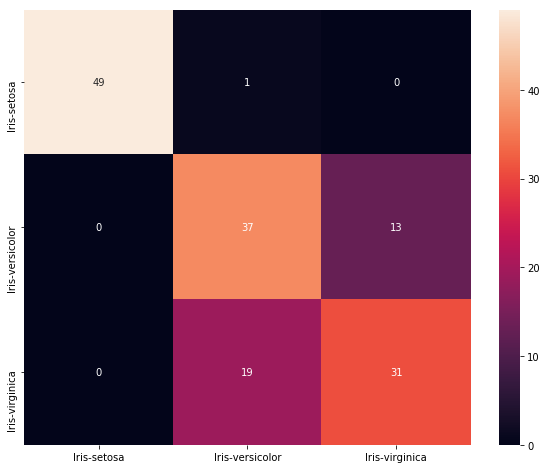

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize = (10,8)) # sets plot size
sns.heatmap(cm_df, annot=True,fmt='d') # creates heat map
plt.show() # shows figure

## Vergleich mit Naive Bayes

Relative Number of mislabeled samples out of a total 150 samples : 22.00%


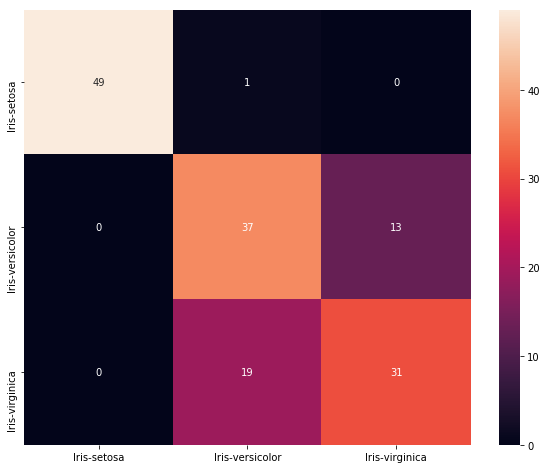

In [9]:
from sklearn.naive_bayes import GaussianNB
gnb = GaussianNB()

X = traindata.iloc[:,[0,1]].values
y_train = traindata.index

gnb.fit(X, y_train)

X_test = testdata.iloc[:,[0,1]].values
y_pred = gnb.predict(X_test)


print("Relative Number of mislabeled samples out of a total %d samples : %.2f%%" 
      % (X_test.shape[0],(y_test != y_pred).sum()/X_test.shape[0]*100))

classes = np.unique(y_pred)
result = confusion_matrix(y_test,y_pred) 
cm_df = pd.DataFrame(
    result, 
    index = [idx for idx in classes],
    columns = [col for col in classes])

plt.figure(figsize = (10,8)) 
sns.heatmap(cm_df, annot=True,fmt='d') 
plt.show() # shows figure